In [2]:

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pylab as plt
%matplotlib inline


# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier



In [1]:
# Some constants
DATA_PATH = "data/Pokemon.csv"
TARGET_COL = "Type 1"
ENCODED_TARGET_COL = "encoded_type_1"
TO_DROP_COLS = ["#", "Name"]
TEST_RATIO = 0.1
SEED = 31415


In [12]:
pokemon_df = pd.read_csv(DATA_PATH)
pokemon_df.sample(5)

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
127,118,Goldeen,Water,NaN,320,45,67,60,35,50,63,1,False
282,260,Swampert,Water,Ground,535,100,110,90,85,90,60,3,False
527,475,GalladeMega Gallade,Psychic,Fighting,618,68,165,95,65,115,110,4,False
320,296,Makuhita,Fighting,NaN,237,72,60,30,20,30,25,3,False
554,495,Snivy,Grass,NaN,308,45,45,55,45,55,63,5,False


In [13]:
target_s = pokemon_df['Type 1']


In [14]:
le = LabelEncoder()
encoded_target_s = pd.Series(le.fit_transform(target_s), name=ENCODED_TARGET_COL)
dummified_target_s = pd.get_dummies(target_s)
dummified_features_df = (pokemon_df.drop(TO_DROP_COLS + [TARGET_COL], axis=1)
                                   .assign(Generation=lambda df: df.Generation.astype(str))
                                   .assign(**{"Legendary": lambda df: df["Legendary"].astype(int), 
                                              "Type 2": lambda df: df["Type 2"].fillna("missing")})
                                   .pipe(pd.get_dummies))
features_and_targets_df = pd.concat([encoded_target_s, dummified_features_df], axis=1)

In [15]:
encoded_target_s.sample(5)

147     6
719     9
543    12
70     14
83      6
Name: encoded_type_1, dtype: int32

In [16]:
le.inverse_transform(encoded_target_s.sample(5))

array(['Fighting', 'Grass', 'Ice', 'Normal', 'Rock'], dtype=object)

In [17]:
dummified_target_s.sample(5)

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
439,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
113,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
649,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
657,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
48,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [18]:
dummified_features_df.sample(5)

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Legendary,Type 2_Bug,Type 2_Dark,...,Type 2_Rock,Type 2_Steel,Type 2_Water,Type 2_missing,Generation_1,Generation_2,Generation_3,Generation_4,Generation_5,Generation_6
405,330,43,30,55,40,65,97,0,0,0,...,0,0,0,1,0,0,1,0,0,0
43,505,73,76,75,81,100,100,0,0,0,...,0,0,0,1,1,0,0,0,0,0
25,413,55,81,60,50,70,97,0,0,0,...,0,0,0,1,1,0,0,0,0,0
653,335,55,40,50,65,85,40,0,0,0,...,0,0,0,0,0,0,0,0,1,0
108,330,40,30,50,55,55,100,0,0,0,...,0,0,0,1,1,0,0,0,0,0


# Correlations 

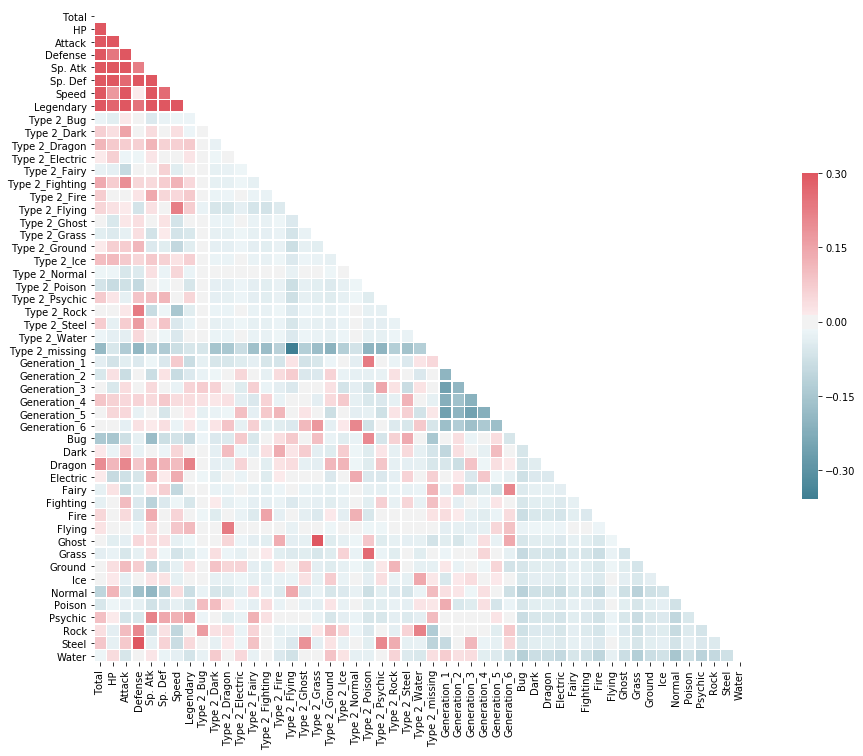

In [33]:
corr_df = pd.concat([dummified_features_df, dummified_target_s], axis=1).corr()


mask = np.zeros_like(corr_df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


f, ax = plt.subplots(figsize=(20, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_df, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [34]:
train_df, test_df = train_test_split(features_and_targets_df, 
                                     stratify=encoded_target_s, 
                                     test_size=TEST_RATIO, random_state=SEED)

In [ ]:
train_df.head(1).T

,526
encoded_type_1,14
Total,518
HP,68
Attack,125
Defense,65
Sp. Atk,65
Sp. Def,115
Speed,80
Legendary,0
Type 2_Bug,0


In [33]:
true_classes = ["a", "b", "c", "a", "c", "c"]
predicted_classes = ["a", "b", "c", "c", "c", "c"]

print("Unbalanced: ")
print("Weighted F1 score:", f1_score(true_classes, predicted_classes, average="weighted"))
print("Micro F1 score:", f1_score(true_classes, predicted_classes, average="micro"))
print("Macro F1 score:", f1_score(true_classes, predicted_classes, average="macro"))

# The three variations of the F1 score for balanced classes are the same

true_classes = ["a", "b", "c", "a", "b", "c"]
predicted_classes = ["a", "b", "c", "a", "b", "c"]
print(32 * "-")

print("Balanaced: ")
print("Weighted F1 score:", f1_score(true_classes, predicted_classes, average="weighted"))
print("Micro F1 score:", f1_score(true_classes, predicted_classes, average="micro"))
print("Macro F1 score:", f1_score(true_classes, predicted_classes, average="macro"))

Unbalanced: 
Weighted F1 score: 0.8174603174603173
Micro F1 score: 0.8333333333333334
Macro F1 score: 0.8412698412698413
--------------------------------
Balanaced: 
Weighted F1 score: 1.0
Micro F1 score: 1.0
Macro F1 score: 1.0


In [34]:
train_features_df = train_df.drop(ENCODED_TARGET_COL, axis=1)
train_target_s = train_df[ENCODED_TARGET_COL]

In [34]:
train_features_df = train_df.drop(ENCODED_TARGET_COL, axis=1)
train_target_s = train_df[ENCODED_TARGET_COL]

In [34]:
def improvement_in_percent(model_score, baseline_score):
    return (100 * (model_score - baseline_score)  / baseline_score).round(3)

# Logistic Regression

In [34]:
lr = LogisticRegression(random_state=SEED)
lr_scores = cross_val_score(lr, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Logistic regression mean and std scores are: ({}, {})".format(lr_scores.mean(), lr_scores.std()))
lr.fit(train_features_df, train_target_s)

Logistic regression mean and std scores are: (0.24622362725009336, 0.02645534667363496)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=31415, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

# Simple XBoost

In [29]:
xgb_clf = XGBClassifier(random_state=SEED)
xgb_clf_scores = cross_val_score(xgb_clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Simple XGBoost classification mean and std scores are: ({}, {})".format(xgb_clf_scores.mean(), xgb_clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(xgb_clf_scores.mean(), lr_scores.mean())))

Simple XGBoost classification mean and std scores are: (0.25648007793247196, 0.03178343800324552)
This is a 4.166 % improvement


# XGBoost classifier


In [30]:
clf = XGBClassifier(random_state=SEED, n_estimators=1000)
clf_scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Alternative XGBoost classification mean and std scores are: ({}, {})".format(clf_scores.mean(), clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(clf_scores.mean(), lr_scores.mean())))

Alternative XGBoost classification mean and std scores are: (0.25721616360416927, 0.025268961819381815)
This is a 4.464 % improvement


# XGBoost classifier (more trees)

In [32]:
clf = XGBClassifier(random_state=SEED, n_estimators=1000)
clf_scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Alternative XGBoost classification mean and std scores are: ({}, {})".format(clf_scores.mean(), clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(clf_scores.mean(), lr_scores.mean())))

Alternative XGBoost classification mean and std scores are: (0.25721616360416927, 0.025268961819381815)
This is a 4.464 % improvement


# XGBoost classifier (smaller learning rate)


In [34]:
clf = XGBClassifier(random_state=SEED, learning_rate=0.01)
clf_scores = cross_val_score(clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Alternative XGBoost classification mean and std scores are: ({}, {})".format(clf_scores.mean(), clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(clf_scores.mean(), lr_scores.mean())))

Alternative XGBoost classification mean and std scores are: (0.2021152982612359, 0.020997775481971143)
This is a -17.914 % improvement


#  Random trees

In [35]:
rf_clf = RandomForestClassifier(random_state=SEED)
rf_clf_scores = cross_val_score(rf_clf, X=train_features_df, y=train_target_s, cv=5, scoring="f1_weighted")
print("Simple random forests classification mean and std scores are: ({}, {})".format(rf_clf_scores.mean(), rf_clf_scores.std()))
print("This is a {} % improvement".format(improvement_in_percent(rf_clf_scores.mean(), lr_scores.mean())))

Simple random forests classification mean and std scores are: (0.2275346239953931, 0.03717503350316851)
This is a -7.59 % improvement
